# **<span style='color:purple'> n-muravev-21 <span>**
---
## **<span style='color:lightblue'> Финальный проект. Вариант №1 <span>**

### В компании, которая разрабатывает мобильные игры, пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

### 1. [В первую очередь, нужно написать функцию для подсчета показателя retention.](#задание-1)
### 2. [Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных нужно определить, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.](#задание-2)
### 3. [Предложить метрики для оценки результатов последнего прошедшего тематического события в игре.](#1-в-игре-plants--gardens-каждый-месяц-проводятся-тематические-события-ограниченные-по-времени-в-них-игроки-могут-получить-уникальные-предметы-для-сада-и-персонажей-дополнительные-монеты-или-бонусы-для-получения-награды-требуется-пройти-ряд-уровней-за-определенное-время-с-помощью-каких-метрик-можно-оценить-результаты-последнего-прошедшего-события)

---
---
## **Библиотеки**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from urllib.parse import urlencode

%matplotlib inline

---
---
## [**Задание 1**](#span-stylecolorpurple-n-muravev-21-span)
### <span style='color:orange'> Retention </span> – один из самых важных показателей в компании. Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

### <span style='color:violet'> shared/problem1-reg_data.csv </span> – данные о времени регистрации
|auth_ts|uid|
|--|--|
|906166566|2|
|906344325|2|
|906686169|2|
|906893386|2|
|906980227|2|

### <span style='color:violet'> shared/problem1-auth_data.csv </span> – данные о времени захода пользователей в игру
|reg_ts|uid|
|--|--|
|906166566|2|
|924422172|3|
|937374732|4|
|947425117|5|
|955630339|6|

### Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.
---

### Первое, что нужно сделать, - считать данные:

In [2]:
problem1_reg_data = pd.read_csv(r'problem1-reg_data.csv', sep=';')
problem1_reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [3]:
problem1_auth_data = pd.read_csv(r'problem1-auth_data.csv', sep=';')
problem1_auth_data

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


---
### Для определения retention в контексте данной задачи нужно определить количество пользователей, зашедших на N день после регистрации, и количество зарегестрированных пользователей. Так каr первый датасет содержит данные по времени регистрации каждого пользователя, то количеством зарегестрированных пользователем в этом случае является количество строк данной таблицы.

In [4]:
users = problem1_reg_data.shape[0]
users

1000000

---
### Чтобы узнать количество пользователей, зашедщих на N день после регистрации, сначала нужно для второй таблицы узнать разность между временем захода в игру и временем регистрации в днях.

In [5]:
# Добавление ко второй таблице данных о времени регистрации пользователя
problem1_data = problem1_auth_data.merge(problem1_reg_data, on='uid', how='left') 
problem1_data

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089
...,...,...,...
9601008,1600874034,1110618,1600874034
9601009,1600874086,1110619,1600874086
9601010,1600874139,1110620,1600874139
9601011,1600874191,1110621,1600874191


In [6]:
# Количество секунд между регистрацией и входом и перевод в количество полных дней
problem1_data['days'] = np.floor((problem1_data.auth_ts - problem1_data.reg_ts) / 60 / 60 / 24).apply(int) 
problem1_data

,auth_ts,uid,reg_ts,days
0,911382223,1,911382223,0
1,932683089,2,932683089,0
2,932921206,2,932683089,2
3,933393015,2,932683089,8
4,933875379,2,932683089,13
...,...,...,...,...
9601008,1600874034,1110618,1600874034,0
9601009,1600874086,1110619,1600874086,0
9601010,1600874139,1110620,1600874139,0
9601011,1600874191,1110621,1600874191,0


---
### Получившуюся таблицу нужно сгруппировать по количеству прошедших дней с регистрации с информацией по количеству зашедших пользователей.

In [7]:
final_df = problem1_data.groupby('days', as_index=0).agg({'uid': 'count'}) \
                        .rename(columns={'uid': 'players'}).sort_values('days')
final_df

,days,players
0,0,1000000
1,1,40202
2,2,42991
3,3,49152
4,4,56070
...,...,...
5911,7715,1
5912,7719,1
5913,7720,1
5914,7726,1


### Как видно в таблице предствален не каждый день, так что стоит сделать таблицу с учетом каждого количества дней до максимального.

In [8]:
df = []
for i in range(final_df.days.max() + 1): 
    df.append(i)
df = pd.DataFrame({'days': df})
df

,days
0,0
1,1
2,2
3,3
4,4
...,...
7724,7724
7725,7725
7726,7726
7727,7727


### Теперь нужно объединить эти таблицы и добавить нули вместо None значений.

In [9]:
final_df = df.merge(final_df, on='days', how='left').fillna(0)
final_df.players = final_df.players.apply(int)
final_df

,days,players
0,0,1000000
1,1,40202
2,2,42991
3,3,49152
4,4,56070
...,...,...
7724,7724,0
7725,7725,0
7726,7726,1
7727,7727,0


---
### Остается последний шаг - поделить количество игроков на количество зарегистрированных пользователей и представить значение в процентах.

In [10]:
final_df['rr'] = ((final_df.players / users) * 100).round(2)
final_df = final_df[['days', 'rr']]
final_df

,days,rr
0,0,100.00
1,1,4.02
2,2,4.30
3,3,4.92
4,4,5.61
...,...,...
7724,7724,0.00
7725,7725,0.00
7726,7726,0.00
7727,7727,0.00


---
### Итоговый результат (retention) получен. Осталось только сделать функцию из всех предыдущих действий.

In [11]:
def retention_rate(problem1_reg_data, problem1_auth_data):
    
    '''Количество зарегестрировавшихся пользователей'''
    users = problem1_reg_data.shape[0] 
    
    '''Добавление ко второй таблице данных о времени регистрации пользователя'''
    problem1_data = problem1_auth_data.merge(problem1_reg_data, on='uid', how='left') 
    
    '''Количество секунд между регистрацией и входом и перевод в количество полных дней'''
    problem1_data['days'] = np.floor((problem1_data.auth_ts - problem1_data.reg_ts) / 60 / 60 / 24).apply(int) 
    
    '''Таблица по количеству пользователей, зашедших на N день после регистрации'''
    final_df = problem1_data.groupby('days', as_index=0).agg({'uid': 'count'}) \
                            .rename(columns={'uid': 'players'}).sort_values('days') 
    
    '''Таблица с учетом каждого дня до максимального дня с момента регистрации'''
    df = []
    for i in range(final_df.days.max() + 1): 
        df.append(i)
    df = pd.DataFrame({'days': df}) 
    
    '''Полная таблица по количеству пользователей, зашедших на N день после регистрации'''
    final_df = df.merge(final_df, on='days', how='left').fillna(0) 
    final_df.players = final_df.players.apply(int)
    
    '''Конечная таблица с retention rate на каждый день от дня регистрации до максимального прошедшего 
    со дня регистрации'''
    final_df['rr'] = ((final_df.players / users) * 100).round(2) 
    
    '''Возвращение конечного результата'''
    return final_df[['days', 'rr']]

## <span style='color:green'> **&check;** </span> **Задание 1**

---
---
## [**Задание 2**](#span-stylecolorpurple-n-muravev-21-span)
### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что <span style='color:orange'> ARPU </span> в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

### Формат **[<span style='color:red'> данных </span>](https://disk.yandex.ru/d/12gk_ATEeBZm4A)**:

|user_id	|revenue	|testgroup|
|--|--|--|
|1	|0	|b|
|2	|0	|a|
|3	|0	|a|
|4	|0	|b|
|5	|0	|b|


---
### Для начала, нужно считать данные по ссылке на яндекс диск:

In [12]:
# Использование api
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/12gk_ATEeBZm4A'  # Ссылка на яндекс диск

# Получение url
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загрузка файла в df
download_response = requests.get(download_url)
df = pd.read_csv(download_url, sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


---
### Нужно обозначить переменные для пользователей и клиенов для контрольной (a) и тестовой (b) групп:

In [13]:
a_clients = 1928
a_users = 202103

b_clients = 1805
b_users = 202667

### На всякий случай стоит посчитать такие метрики, как ARPU, ARPPU, CR1. Так же посмотреть более точное различие ARPU между контрольной и тестовой группами:

In [14]:
a_arpu = df[df.testgroup == 'a'].revenue.sum() / a_users
a_arpu

25.413719736965806

In [15]:
b_arpu = df[df.testgroup == 'b'].revenue.sum() / b_users
b_arpu

26.75128659327863

In [16]:
(b_arpu - a_arpu) / a_arpu * 100

5.263168360069894

In [17]:
a_arppu = df[df.testgroup == 'a'].revenue.sum() / a_clients
a_arppu

2663.9984439834025

In [18]:
b_arppu = df[df.testgroup == 'b'].revenue.sum() / b_clients
b_arppu

3003.6581717451522

In [19]:
a_cr1 = a_clients / a_users
a_cr1

0.009539690157988749

In [20]:
b_cr1 = b_clients / b_users
b_cr1

0.008906235351586593

#### Конверсия в обоих группах порядка 1% (0.9%)

### Можно посмотреть процентное различие метрик ARPPU и CR1 для групп, как для ARPU:

In [21]:
(b_arppu - a_arppu) / a_arppu * 100

12.749997227996351

In [22]:
(b_cr1 - a_cr1) / a_cr1 * 100

-6.640203150326494

### В результате имеется следующая информация о различиях между контрольной и тестовой группой:
>  * <span style='color:orange'> ARPU </span> (средний доход с привлеченного пользователя) тестовой группы больше контрольной на 5%
>  * <span style='color:orange'> ARPPU </span> (средний доход с привлеченного клиента) тестовой группы больше контрольной на 13%
>  * <span style='color:orange'> CR1 </span> (конверсия из пользователя в клиента) тестовой группы меньше контрольной на 7%

---
### Таблица сгруппирована по пользователям, то есть как минимум информации о повторных покупках просто нет. Поэтому возникают вопросы по поводу сути акционного предложения. Стоит более внимательно рассмотреть клиентов обеих групп (через описание и гистограмму по данным о доходах).

In [23]:
a_client_df = df[(df.testgroup == 'a') & (df.revenue != 0)].sort_values('revenue')
b_client_df = df[(df.testgroup == 'b') & (df.revenue != 0)].sort_values('revenue')

---
#### ***Контрольная группа:***

In [24]:
# Описание данных контрольной группы
a_client_df.revenue.describe() 

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

<AxesSubplot:xlabel='revenue', ylabel='Count'>

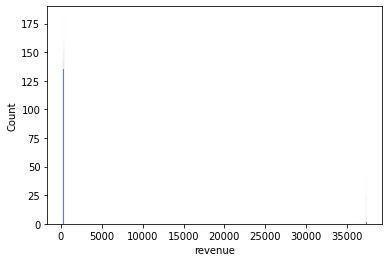

In [25]:
sns.histplot(a_client_df.revenue)

### По описанию клиентов контрольной группы, видно, что более, чем 3/4 покупок не превосходят 400 у.е. по стоимости. Возможно стоит посмотреть на данные с учетом этой условной границы:

In [26]:
# Описание данных о клиентах контрольной группы, заплативших более 400 у.е.
a_client_df[a_client_df.revenue > 400].revenue.describe() 

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

<AxesSubplot:xlabel='revenue', ylabel='Count'>

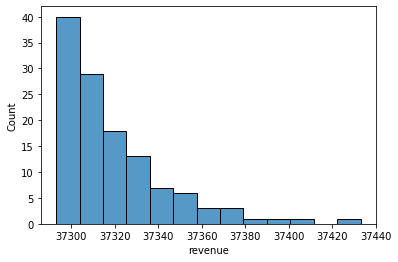

In [27]:
sns.histplot(a_client_df[a_client_df.revenue > 400].revenue)

In [28]:
# Описание данных о клиентах контрольной группы, заплативших не более 400 у.е.
a_client_df[a_client_df.revenue <= 400].revenue.describe() 

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

<AxesSubplot:xlabel='revenue', ylabel='Count'>

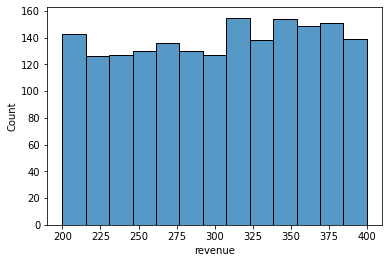

In [29]:
sns.histplot(a_client_df[a_client_df.revenue <= 400].revenue)

### Взятая граница оказалась удачной. В результате в данных виден выброс в виде 123 клиентов, отдавших более 37000 у.е., когда как стоимость покупки большей части клиентов контрольной группы была в пределах от 200 до 400 у.е.

In [30]:
# Отношение дохода с клиентов с покупкой более 400 у.е. к доходу с клиентов с покупкой не более 400 у.е.
a_client_df[a_client_df.revenue > 400].revenue.sum() / a_client_df[a_client_df.revenue <= 400].revenue.sum() 

8.40802510179746

In [35]:
a_client_df[a_client_df.revenue <= 400].revenue.count() / a_client_df[a_client_df.revenue > 400].revenue.count()

14.674796747967479

### Итого, получается, что основной доход в контрольной группе идет от резко выделяющегося меньшинства клиентов (как видно более чем в 8 раз превышает доход с основной массы клиентов (\~90% от всего дохода), при условии того, что количество этих клиентов почти в 15 раз меньше (\~6% от всех клиентов])).

---
#### ***Тестовая группа:***

In [31]:
b_client_df.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

<AxesSubplot:xlabel='revenue', ylabel='Count'>

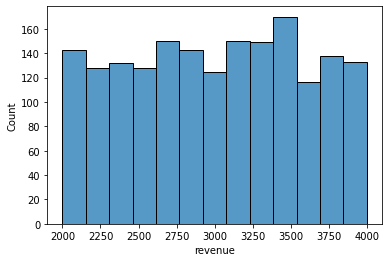

In [32]:
sns.histplot(b_client_df.revenue)

### В отличие от контрольной группы данные тестовой группы имеют относительно равномерное распределение в своих пределах. Также четко наблюдается схожесть данных тестовой группы с данными контрольной группы о клиентах с покупкой не более 400 у.е. (исключая разницу дохода в 10 раз). Помимо, интересной особенностью является одинаковое количество клиентов в этих группах.

In [33]:
b_client_df.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

In [34]:
a_client_df[a_client_df.revenue <= 400].revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

### То есть характерность совершения клиентами покупок (для большинства пользователей) сохраняется, не смотря на увеличение цен в 10 раз.

---
### **Вывод**
### С учетом рассмотрения вышеперечисленных элементов, набор предложений в тестовых данных выглядит более стабильным. Отличия в конверсии не так значительны при условии того, что значения конверсии в обоих датасетах равны порядка одному проценту. При этом, что общий доход, что ARPU и ARPPU выше в тестовом наборе данных. Также сравнимый величину метрик в контрольной группе определяет меньшинство (порядка 6% от всех клиентов обеспечивает 90% дохода всей группы), тогда как в тестовой группе со всех клиентов идет более-менее раавномерный доход. <span style='color:red'> ***Исходя из всего этого, тестовый набор предложений выглядит лучше контрольного.*** </span>

## <span style='color:green'> **&check;** </span> **Задание 2**

---
---
## [**Задание 3**](#span-stylecolorpurple-n-muravev-21-span)
### 1. В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

### 2. Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

---

### **1.**  

  * ###    Первые метрики, с помощью которых можно оценить успешность события, - это количество активных пользователей до события, во время его проведения и после него. Как увеличенное возвращение в игру старых пользователей, так и увеличенное привлечение новых пользователей будет говорить об успешности события. 

  * ###    Помимо на заинтересованность в событии может указывать конверсия пользователей в участвующих в событии пользователей. Говоря о конверсии, также можно посмотреть на конверсию по прохождению уровней (отношение количества прошедших уровень к количеству прошедших предыдущий уровень) или конверсию из принявших участие в событии в прошедших событие. Тут же можно посмотреть на метрику среднего количества проигрышей на уровень на пользователя, принявшего участие в событии.

  * ###   Временные метрики тоже могут показать заинтересованность пользователей в событии. Например, среднее время игровой сессии на пользователя, или среднее время, затрачиваемое на уровень, либо отношение времени, затраченного на событие, к общему времени игровой сессии пользователя (среди всех активных пользователей, либо пользователей, принявших участие в событии). В дополнение можно посмотреть в принципе на среднее количество сессий.

  * ###    Еще можно посмотреть на денежные метрики, но тут будет зависеть от того, каким способом происходит монетизация в игре. Самыми распространенными вариантами будут внутреигровые транзакции, либо непрямая монетизация (через рекламу). Очевидно для обоих вариантов нужно смотреть на общий доход, помимо этого - конверсия в клиентов, повторную покупку, либо количество просмотров рекламы на пользователя (либо на игровую сессию). Также здесь можно посмотреть на такие метрики как ARPU, ARPPU, ARPDAU.

  * ###    В конечном счете результаты последнего прошедшего события можно оценить, сравнив как с результатами предшествующего события, так и с предсобытионного преиода.
---

### **2.**

  * ###    В большинстве своем метрики останутся такими же, за исключением некоторых. Например добавится такая метрика, как максимальный уровень, до которого дошел пользователь (так как в предыдущем задании этот уровень был последним по счету, то здесь из-за отката по уровням такой подход не подойдет), соответственно поуровневая конверсия должна будет считаться, исходя из этой метрики.

  * ###    Еще расчет среднего времени, затрачиваемого на уровень, будет зависеть от игрового жанра события, так как в случае головоломки при откате на несколько уровней назад время перепрохождения будет значительно меньше, так как паттерн будет уже известен, соответственно, среднее время нужно будет рассчитываться по времени от первого попадания на уровень до первого прохождения пользователем уровня (именно все время нахождения на самом уровне до его первого прохождения). В другом случае будет считаться так же, как и в предыдущем варианте.
---
